# 单进程，单线程，实现非阻塞并发

- 套接字设置为非阻塞
- 代码：tcp_socket.setblocking(False)

In [ ]:
import socket
tcp_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
tcp_socket.setblocking(False) # 套接字设置为非阻塞
tcp_socket.listen()
client = list()
# 未设置循环退出条件，暂时注释掉
# while True:
try:
    # 非阻塞下没有连接则报异常
    client_socket, client_addr = tcp_socket.accept()
except Exception as ret:
    pass
else:
    client_socket.setblocking(False) # 套接字设置为非阻塞
    client.append(client_socket)
    
for c in client:
    try:
        recv_msg = c.recv(1024)
    except Exception as ret:
        pass
    else:
        if recv_msg:
            print(recv_msg.decode("utf-8"))
        else:
            c.close()
            client.remove(c)

- 对于TCP协议，确定一条链路，只要五元组（源IP、源端口号、目标IP、目标端口号、协议）唯一就可以了.

- recv实际为读取接收缓冲区，应加快recv循环提取数据，避免缓存溢出

# 短连接与长连接

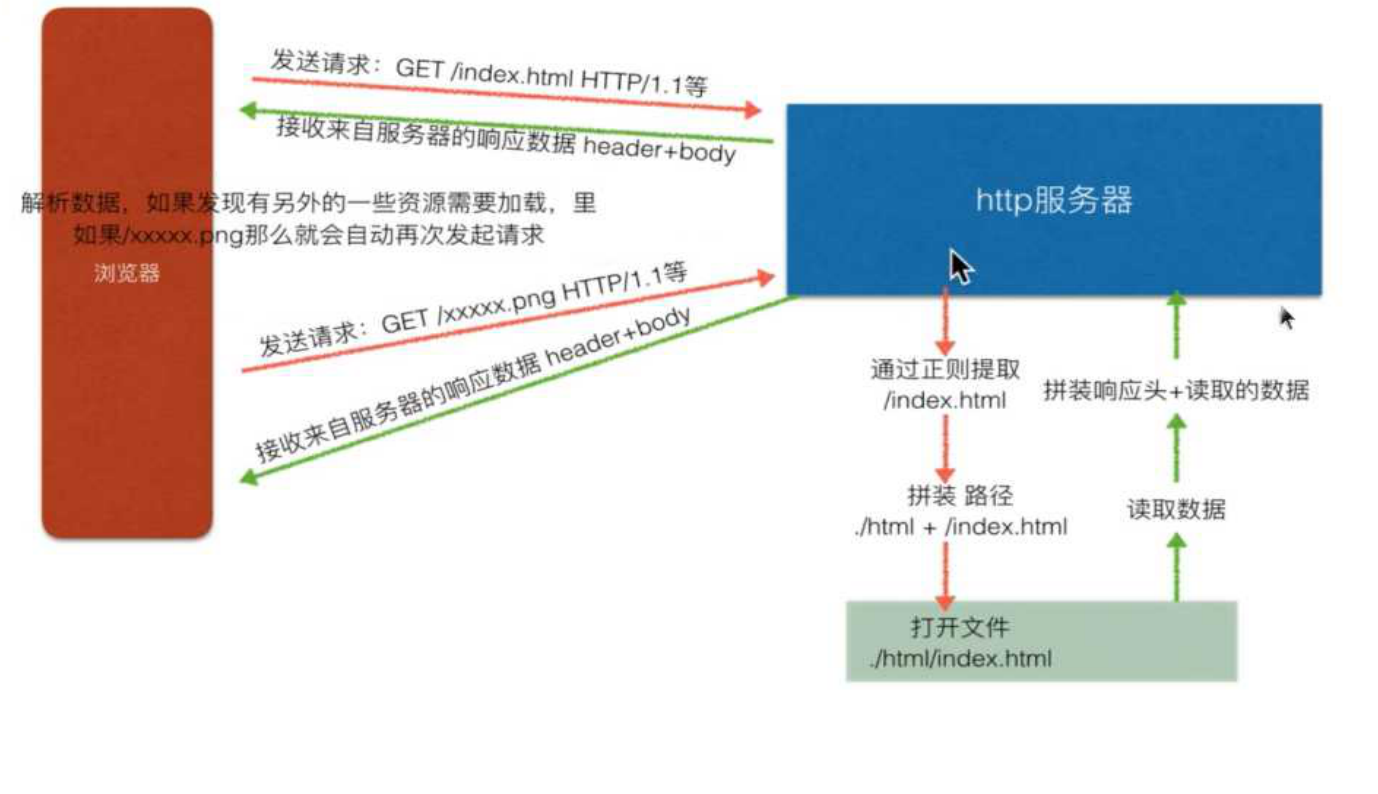

- HTTP/1.1协议采用长连接，HTTP/1.0采用短连接
- 长连接：服务器不主动断开，但需要使浏览器主动断开
- 短连接：服务器响应后，主动断开连接(需要设置来取消TIME_WAIT状态)

### 长连接：实现使浏览器主动断开

```
'HTTP/1.1 200 OK\r\n'
'Content-Length:长度\r\n'
'\r\n'

相应的body长度接收完，浏览器发起close()
```

# epoll
- select-->poll-->epoll
- 只能用于linux
- nginx,apache
- fd文件表示符
- 事件通知：socket连接，有数据到达则通知其可以接收
- 内核态（系统内存），用户态（程序内存）
- 
- **1.epoll与kernel共享一块内存（内存映射mmap），减少用户态到内核态复制过程；**
- **2.采用事件分发（事件就绪通知）机制，非轮询**

In [1]:
import select

# 创建一个epoll对象
epl = select.epoll()
# 将套接字对应的fd注册到
epl.register(tcp_server_socket.fileno(), select.EPOLLIN)
# 创建字典储存{fd:socket}，方便查找
fd_event_dict = dict()
while True:
    fd_event_list = epl.poll() # 阻塞，监听事件,返回列表
    # fd_event_list：[(fd, event),]
    for fd, event in fd_event_list:
        if fd == tcp_server_socket.fileno():
            new_socket, new_addr = tcp_server_socket.accept()
            epl.register(new_socket.fileno(), select.EPOLLIN)
            fd_event_dict[new_socket.fileno()] = new_socket
        elif event == select.EPOLLIN:
            recv_msg = fd_event_dict[fd].recv(1024)
            if recv_msg:
                msg = recv_msg.decode('utf-8')
                print(msg)
            else:
                fd_event_dict[fd].close()
                epl.unregister(fd)
                del fd_event_dict[fd]